In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"poojasasikumar","key":"282f536ea08093c9f4f656abb52a81ba"}'}

In [ ]:
import os
import shutil

# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json file to the .kaggle directory
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Set the permissions of the kaggle.json file
os.chmod('/root/.kaggle/kaggle.json', 600)


In [ ]:
# Define the path where you want to save the dataset in your Google Drive
dataset_path = '/content/drive/MyDrive/eye_diseasess_classification'

# Create the directory if it doesn't exist
os.makedirs(dataset_path, exist_ok=True)

# Change the current working directory to the dataset path
os.chdir(dataset_path)

# Download the dataset using Kaggle API
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

# Unzip the downloaded dataset
!unzip eye-diseases-classification.zip -d .

# Optionally, remove the zip file to save space
os.remove('eye-diseases-classification.zip')


Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
Archive:  eye-diseases-classification.zip
  inflating: ./dataset/cataract/0_left.jpg  
  inflating: ./dataset/cataract/103_left.jpg  
  inflating: ./dataset/cataract/1062_right.jpg  
  inflating: ./dataset/cataract/1083_left.jpg  
  inflating: ./dataset/cataract/1084_right.jpg  
  inflating: ./dataset/cataract/1102_left.jpg  
  inflating: ./dataset/cataract/1102_right.jpg  
  inflating: ./dataset/cataract/1115_left.jpg  
  inflating: ./dataset/cataract/1126_right.jpg  
  inflating: ./dataset/cataract/112_right.jpg  
  inflating: ./dataset/cataract/1144_left.jpg  
  inflating: ./dataset/cataract/1144_right.jpg  
  inflating: ./dataset/cataract/1164_left.jpg  
  inflating: ./dataset/cataract/1167_right.jpg  
  inflating: ./dataset/cataract/119_left.jpg  
  inflating: ./dataset/cataract/1285_left.jpg  
  inflating: ./dataset/cataract/1415_left.jpg  
  inflating: ./dataset/cataract

In [ ]:
import os

# Path to the dataset directory
dataset_dir = '/content/drive/MyDrive/eye_diseasess_classification/dataset'

# List files and directories inside the 'dataset' folder
print(os.listdir(dataset_dir))


['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.9 MB/s eta 0:00:00


## **Pre Processing**

In [ ]:
import os
import cv2
import numpy as np
import pywt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Google Drive path for saving preprocessed data
save_path = '/content/drive/MyDrive/eye_diseasess_classification/preprocessed_stacked'
os.makedirs(save_path, exist_ok=True)

IMG_SIZE = (224, 224)
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
original_data_path = '/content/drive/MyDrive/eye_diseasess_classification/dataset'

# ---------- Updated Preprocessing Functions ----------

# Replacing wavelet with Gaussian blur on Red channel
def wavelet_transform(image):
    _, _, r = cv2.split(image)
    return cv2.GaussianBlur(r, (5, 5), 0)

# CLAHE on Green channel
def apply_clahe(image):
    _, g, _ = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    return clahe.apply(g)

# Binary thresholding on Blue channel
def blood_vessel_segmentation(image):
    b, _, _ = cv2.split(image)
    _, segmented = cv2.threshold(b, 100, 255, cv2.THRESH_BINARY)
    return segmented

# ---------- Preprocessing and Saving ----------

def preprocess_and_save_all():
    for class_name in classes:
        class_input_path = os.path.join(original_data_path, class_name)
        class_output_path = os.path.join(save_path, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        for filename in tqdm(os.listdir(class_input_path), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_input_path, filename)
            try:
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMG_SIZE)

                wavelet = cv2.resize(wavelet_transform(image), IMG_SIZE)
                clahe = cv2.resize(apply_clahe(image), IMG_SIZE)
                vessel = cv2.resize(blood_vessel_segmentation(image), IMG_SIZE)

                # Stack all into 3 channels
                stacked = np.stack([wavelet, clahe, vessel], axis=-1)

                # Save the stacked image as .npy (fast for loading later)
                np.save(os.path.join(class_output_path, filename.split('.')[0] + '.npy'), stacked)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Run the preprocessing
preprocess_and_save_all()


Processing normal: 100%|██████████| 1074/1074 [00:20<00:00, 51.55it/s]


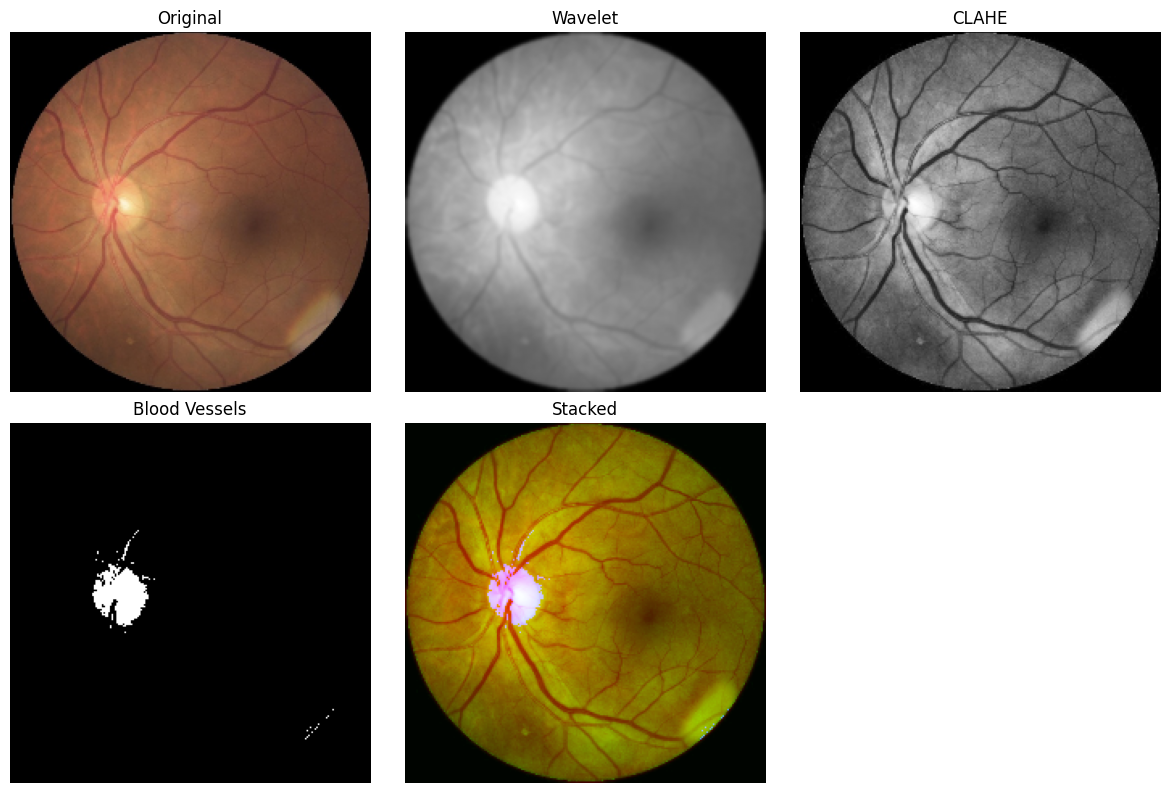

In [ ]:
def show_preprocessing_steps(class_name='normal'):
    # Choose a sample file from the preprocessed folder
    class_folder = os.path.join(original_data_path, class_name)
    sample_file = os.listdir(class_folder)[0]
    sample_path = os.path.join(class_folder, sample_file)

    image = cv2.imread(sample_path)
    image = cv2.resize(image, IMG_SIZE)
    wavelet = wavelet_transform(image)
    clahe = apply_clahe(image)
    vessel = blood_vessel_segmentation(image)
    stacked = np.stack([wavelet, clahe, vessel], axis=-1)

    # Display
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1); plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
    plt.subplot(2, 3, 2); plt.imshow(wavelet, cmap='gray'); plt.title("Wavelet"); plt.axis('off')
    plt.subplot(2, 3, 3); plt.imshow(clahe, cmap='gray'); plt.title("CLAHE"); plt.axis('off')
    plt.subplot(2, 3, 4); plt.imshow(vessel, cmap='gray'); plt.title("Blood Vessels"); plt.axis('off')
    plt.subplot(2, 3, 5); plt.imshow(stacked.astype('uint8')); plt.title("Stacked"); plt.axis('off')
    plt.tight_layout()
    plt.show()

show_preprocessing_steps('normal')


In [ ]:
def load_stacked_images(preprocessed_path):
    X = []
    y = []
    class_map = {c: i for i, c in enumerate(classes)}

    for class_name in classes:
        class_dir = os.path.join(preprocessed_path, class_name)
        for file in os.listdir(class_dir):
            if file.endswith('.npy'):
                arr = np.load(os.path.join(class_dir, file))
                X.append(arr)
                y.append(class_map[class_name])

    return np.array(X), np.array(y)

# Load from saved .npy files
X_data, y_data = load_stacked_images(save_path)


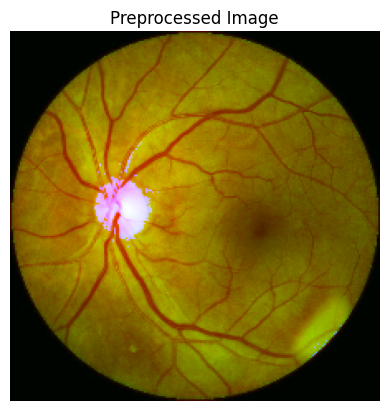

In [ ]:
import numpy as np
import os
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Dataset directory containing preprocessed images (npy files)
dataset_dir = '/content/drive/MyDrive/eye_diseasess_classification/preprocessed_stacked'

# Image size for the model (e.g., 224x224 for VGG)
IMG_SIZE = (224, 224)

# Function to load and preprocess preprocessed image
def load_preprocessed_image(image_path):
    # Load preprocessed .npy image
    image = np.load(image_path)
    # Ensure the image is the correct shape (2D or 3D as needed)
    if len(image.shape) == 2:  # grayscale image
        image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return cv2.resize(image, IMG_SIZE)

# Example for a single image path (testing loading)
example_img_path = '/content/drive/MyDrive/eye_diseasess_classification/preprocessed_stacked/normal/1034_left.npy'
preprocessed_image = load_preprocessed_image(example_img_path)

# Display the preprocessed image to verify it's correctly loaded
plt.imshow(preprocessed_image.squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()


In [ ]:
# Create a simple data generator for loading and batching preprocessed images
def load_data_from_npy(dataset_dir):
    images = []
    labels = []

    class_names = os.listdir(dataset_dir)
    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith(".npy"):
                    img_path = os.path.join(class_dir, filename)
                    image = load_preprocessed_image(img_path)  # Load preprocessed image
                    images.append(image)
                    labels.append(class_names.index(class_name))  # Label is the class index

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load the full dataset
X_data, y_data = load_data_from_npy(dataset_dir)

# Check shape of the dataset
print("Training data shape:", X_data.shape)  # Should be (num_samples, 224, 224, channels)
print("Labels shape:", y_data.shape)



Training data shape: (4217, 224, 224, 3)
Labels shape: (4217,)


In [ ]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

## **ConvNext**

In [ ]:
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Load the ConvNeXt model pre-trained on ImageNet, excluding the top layer (for fine-tuning)
base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base (if you want to fine-tune only the top layers)
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for our classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # 4 output classes

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [ ]:
# Train the model on the preprocessed data
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 90s 602ms/step - accuracy: 0.6505 - loss: 1.1283 - val_accuracy: 0.8566 - val_loss: 0.3940
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 429ms/step - accuracy: 0.8880 - loss: 0.3317 - val_accuracy: 0.8483 - val_loss: 0.4458
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 445ms/step - accuracy: 0.8798 - loss: 0.3325 - val_accuracy: 0.8791 - val_loss: 0.3071
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 46s 435ms/step - accuracy: 0.8963 - loss: 0.2623 - val_accuracy: 0.8827 - val_loss: 0.2856
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 447ms/step - accuracy: 0.9210 - loss: 0.2285 - val_accuracy: 0.8436 - val_loss: 0.4210
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 46s 435ms/step - accuracy: 0.9046 - loss: 0.2503 - val_accuracy: 0.8898 - val_loss: 0.2862
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 47s 443ms/step - accuracy: 0.9230 - loss: 0.1970 - val_accuracy: 0.8993 - val_loss: 0.2666
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 436ms/step - accuracy: 0.9298 - loss: 0

In [ ]:
# Evaluate model on validation data
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.8885 - loss: 0.3274
Validation Accuracy: 89.93%


In [ ]:
model.save('/content/drive/MyDrive/convnext_eye_disease_model.h5')


### Finetunning ConvNxt

In [ ]:
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load ConvNeXtBase with frozen base (already trained for 10 epochs)
base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Initial training (already done, just showing for completeness)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32)

# Step 2: Unfreeze last few layers for fine-tuning
for layer in base_model.layers[-20:]:  # You can adjust this number based on the architecture
    layer.trainable = True

# Step 3: Re-compile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Fine-tune the model
history_finetune = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 87s 628ms/step - accuracy: 0.6444 - loss: 1.0835 - val_accuracy: 0.8282 - val_loss: 0.4579
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 58s 445ms/step - accuracy: 0.8594 - loss: 0.3815 - val_accuracy: 0.8412 - val_loss: 0.4498
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 440ms/step - accuracy: 0.8908 - loss: 0.3047 - val_accuracy: 0.8543 - val_loss: 0.3781
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - accuracy: 0.8977 - loss: 0.2680 - val_accuracy: 0.8981 - val_loss: 0.2819
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - accuracy: 0.9061 - loss: 0.2399 - val_accuracy: 0.8981 - val_loss: 0.2730
Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 127s 909ms/step - accuracy: 0.9305 - loss: 0.1977 - val_accuracy: 0.9064 - val_loss: 0.2577
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 104s 676ms/step - accuracy: 0.9389 - loss: 0.1653 - val_accuracy: 0.9052 - val_loss: 0.2656
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 678ms/step - accuracy: 0.9454 - loss: 0.1523 

In [ ]:
# Final evaluation on validation data
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Final Validation Accuracy after Fine-Tuning: {val_acc * 100:.2f}%')

# Final evaluation on training data
train_loss, train_acc = model.evaluate(X_train, y_train)
print(f'Final Training Accuracy after Fine-Tuning: {train_acc * 100:.2f}%')


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.8912 - loss: 0.2924
Final Validation Accuracy after Fine-Tuning: 90.64%
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 374ms/step - accuracy: 0.9555 - loss: 0.1398
Final Training Accuracy after Fine-Tuning: 95.70%


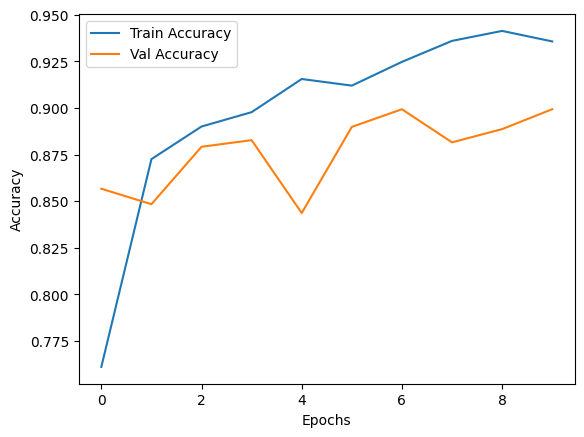

In [ ]:
# Display training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 704ms/step


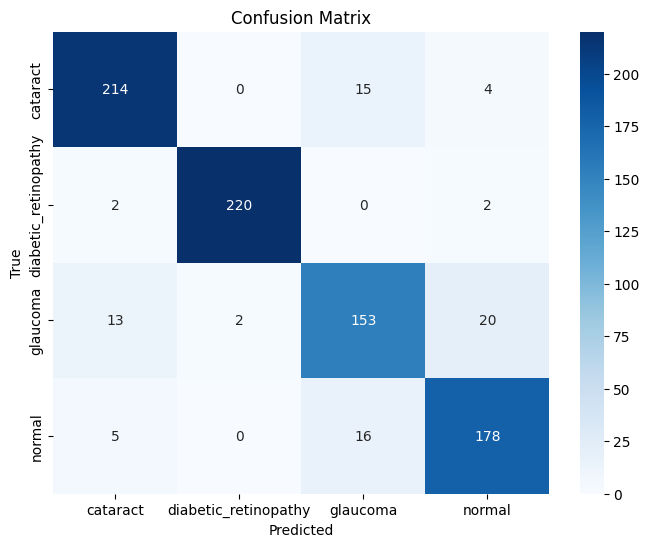

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.91      0.92      0.92       233
diabetic_retinopathy       0.99      0.98      0.99       224
            glaucoma       0.83      0.81      0.82       188
              normal       0.87      0.89      0.88       199

            accuracy                           0.91       844
           macro avg       0.90      0.90      0.90       844
        weighted avg       0.91      0.91      0.91       844



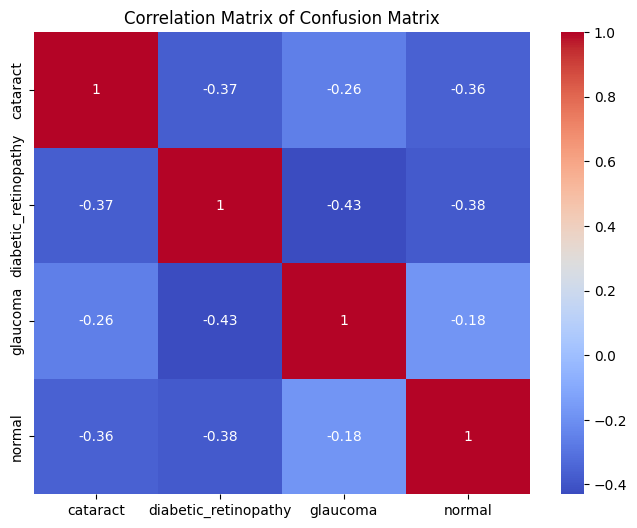

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on validation set
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Correlation Matrix of Confusion Matrix
plt.figure(figsize=(8, 6))
correlation_matrix = np.corrcoef(cm)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=classes, yticklabels=classes)
plt.title("Correlation Matrix of Confusion Matrix")
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 517ms/step


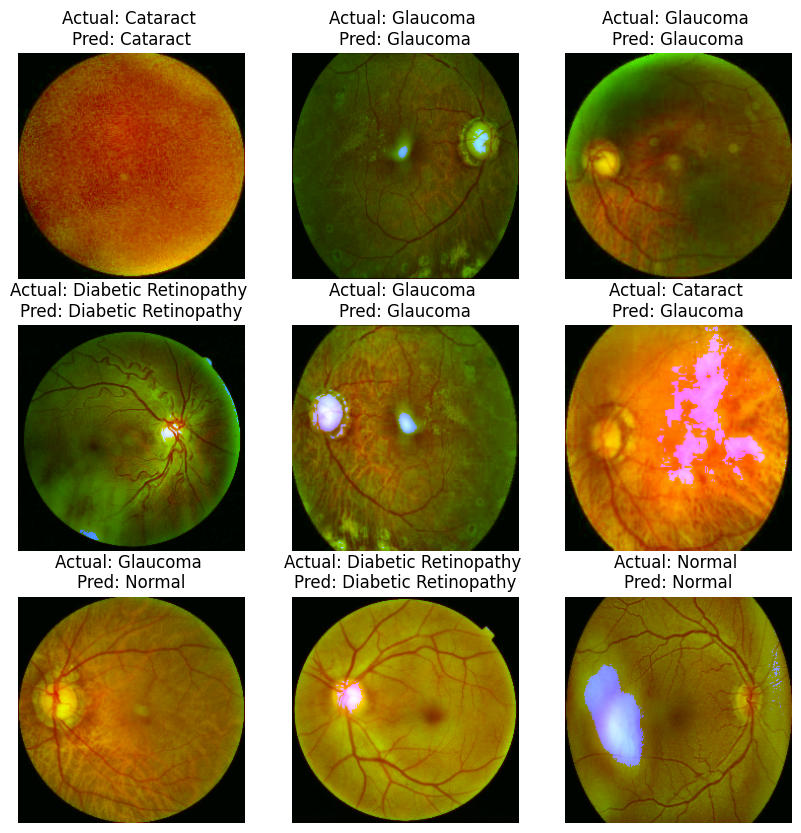

In [ ]:
def display_actual_vs_predicted(model, X_test, y_test, class_labels):
    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Plot some of the images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_test[i])
        plt.title(f"Actual: {class_labels[np.argmax(y_test[i])]} \nPred: {class_labels[y_pred_classes[i]]}")
        plt.axis('off')
    plt.show()

# Example: Assuming you have your test data loaded in X_test and y_test
class_labels = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']  # Modify as per your classes
display_actual_vs_predicted(model, X_val, y_val, class_labels)
